# Vertical Land Motion from GNSS for Terschelling

#### Datasets required to run this notebook:
- Vertical component of the GNSS solution for the permanent station in the harbour of Terschelling from the [Nevada Geodetic Laboratory NGL14](http://geodesy.unr.edu/NGLStationPages/stations/TERS.sta), here downloaded from [SONEL](https://www.sonel.org/?page=gps&idStation=2035). Filename: `GNSS_wTERS_13534M001_NGL14.neu`
- Dates of receiver and antenna changes (available from the website of the [TU Delft](http://gnss1.tudelft.nl/dpga/station/Terschelling.html#TERS)). Filename: `GNSS_ters_receiver-antenna-changes.txt`

**Required python modules**
- [coastal_data](https://github.com/3enedix/coastal-sea-level/tree/main/coastal_data)

In [1]:
# Fill in your datapaths
main_datapath_input = '/home/bene/PhD-docs/80_papers/1_dataset_combination/data/input/'
main_datapath_output = '/home/bene/PhD-docs/80_papers/1_dataset_combination/data/output/'

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from coastal_data import CD_statistics

In [3]:
# matplotlib fontsizes
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# png image resolution
dpi = 300

### Plot function

In [5]:
colour_list = ['k', 'mediumblue', 'limegreen']
def plot_timeseries(data, title='', offsets=[]):
    plt.figure(figsize=(15,8))
    plt.grid() 
    plt.title(title,fontsize=25)    
    plt.xticks(fontsize=12);
    plt.yticks(fontsize=12);    
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Height [m]', fontsize=12)
    
    for i in range (0, len(data)):
        plt.plot(data[i]['x_data'], data[i]['y_data'], label=data[i]['label'], c=colour_list[i])
        plt.legend(fontsize=12, loc='lower right') # upper, lower, center
        
    # Vertical lines for the receiver changes
    if len(offsets) == 0:
        plt.vlines(change_dates['date'], ymin=-0.03, ymax=0.03, color='crimson', label='antenna & receiver changes')
    else:
        for i in range(0, len(offsets)):
            plt.vlines(pd.to_datetime(change_dates['date'][offsets[i]]), ymin=-0.03, ymax=0.03, color='crimson')
            
    plt.legend(fontsize=12, loc='upper right')

### Receiver and antenna changes

In [6]:
change_dates = pd.read_csv(main_datapath_input + 'GNSS_ters_receiver-antenna-changes.txt', header=0, names=['date'])
duplos = change_dates.duplicated()
change_dates = change_dates[~duplos]
change_dates.sort_values(by='date', inplace=True)
change_dates.set_index(pd.Index(range(0,len(change_dates))), inplace=True)

### NGL14 - Get and prepare the data

In [7]:
# Absolute position from input file. Reference epoch: 2009.5496. Datum: ITRF14 (ellipsoid: GRS80)
ngl_lat = 53.36273935 # [deg]
ngl_lon = 5.21939031 # [deg]
ngl_height = 56.1050 # [m]

In [8]:
col_names = ['DN', 'DE', 'DU', 'SDN', 'SDE', 'SDU'] # DN, DE and DU are in [m]
ngl = pd.read_csv(main_datapath_input + 'GNSS_wTERS_13534M001_NGL14.neu', skiprows=26, header=0, names=col_names, sep='    |  ', engine='python')

In [9]:
# Convert dates from decimal numbers to datetime
years = ngl.index.astype('int')
doy = np.round(((ngl.index - years) *12 *30.5),0).astype('int')

date = []
for i in range(0,len(doy)):
    if doy[i] == 0:
        day = (doy[i] + 1).astype('str')
    else:
        day = (doy[i]).astype('str')
    day.rjust(3 + len(day), '0')
    year = years[i].astype('str')
    date.append(datetime.strptime(year + "-" + day, "%Y-%j").strftime("%m-%d-%Y"))

date = pd.to_datetime(date)
ngl['date'] = date
ngl['decim_date'] = ngl.index
ngl = ngl.set_index('date', drop='False')

# Remove duplicates
duplos = ngl.index.duplicated()
ngl = ngl[~duplos]

# Remove unnecessary columns
ngl = ngl.drop(['DN', 'DE', 'SDN', 'SDE'], axis=1)

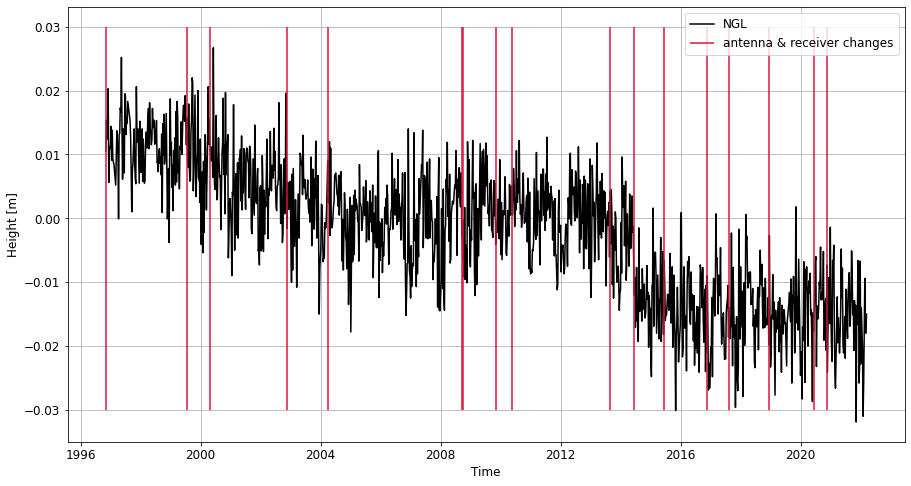

In [10]:
plt_dset1 = {'x_data':ngl.index, 'y_data':ngl['DU'], 'label':'NGL'}
plt_dset = [plt_dset1]
plot_timeseries(plt_dset, title='')

### Estimate the step function with offsets at the given times of receiver/antenna changes

In [11]:
A = np.zeros((len(ngl), len(change_dates)), dtype='int')
A[:,0] = 1
for i in range(0, len(change_dates)-1):
    # index in the data when receiver was changed:
    idx = max((np.where(ngl.index <= change_dates['date'][i+1])[0]))
    A[idx:, i+1] = 1
    
N = np.matmul(np.transpose(A),A) # A'A
n = np.matmul(np.transpose(A),ngl['DU']) # A'l
xs = np.linalg.solve(N,n)
ls = np.matmul(A, xs)

### Adjust the data
Not all receiver/antenna changes lead to significant offsets. Therefore try successively removing "large" offsets and compare the trends. Determining what a "significant" offset is, is a highly arbitrary choice affecting the resulting trend.

In [12]:
sections = [] # list of DataFrames with the blocks between receiver/antenna changes

for i in range(1, len(change_dates)):
    rctemp_lower = change_dates['date'][i-1] # receiver change earlier point in time
    rctemp_upper = change_dates['date'][i] # receiver change later point in time
    section = ngl[(ngl.index >= rctemp_lower) & (ngl.index <= rctemp_upper)]
    sections.append(section)

# Section after the last receiver change:
section = ngl[ngl.index > rctemp_upper]
sections.append(section)

In [13]:
# Original trend without cleaning any jumps
CD_statistics.compute_trend(ngl['decim_date'].values, ngl['DU'].values*1000) # mm/year

-1.1483

#### 1) Consider only the 9 mm offset at index 10
This offset is also clearly visible in the time series of the East-component

In [14]:
idx1 = 10
ngl_adjusted1 = pd.DataFrame(columns=['date', 'DU']).set_index(['date'])

for i in range(0,len(sections)):
    if i < idx1:
        new_temp = pd.DataFrame({'DU':sections[i].loc[:, ('DU')]})
    else:
        new_temp = pd.DataFrame({'DU':sections[i].loc[:, ('DU')] - xs[idx1]})
    ngl_adjusted1 = pd.concat([ngl_adjusted1, new_temp])

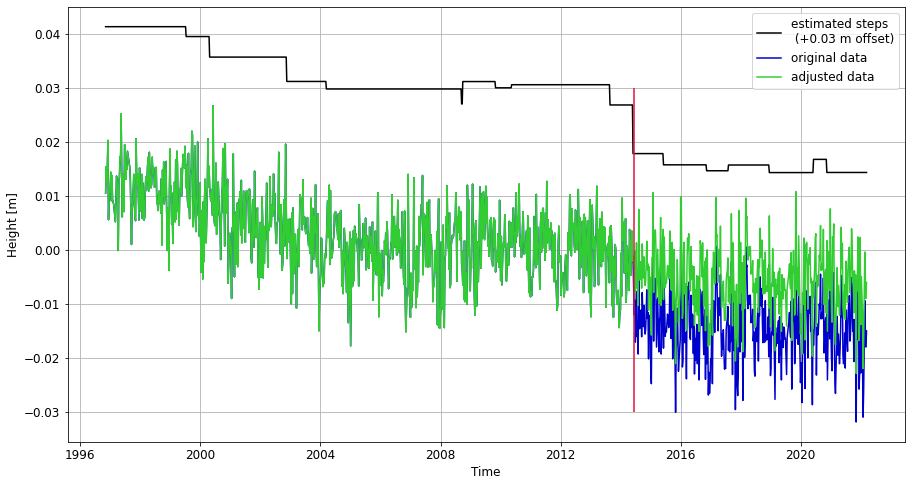

In [15]:
plt_dset1 = {'x_data':ngl.index, 'y_data':ls+0.03, 'label':'estimated steps\n (+0.03 m offset)'}
plt_dset2 = {'x_data':ngl.index, 'y_data':ngl_adjusted1['DU'], 'label':'adjusted data'}
plt_dset3 = {'x_data':ngl.index, 'y_data':ngl['DU'], 'label':'original data'}
plt_dset = [plt_dset1, plt_dset3,plt_dset2]
offsets = [idx1]
plot_timeseries(plt_dset, title='', offsets=offsets)

In [16]:
CD_statistics.compute_trend(ngl['decim_date'].values, ngl_adjusted1['DU'].values.astype('float')*1000) # mm/year

-0.6933

In [17]:
ngl_adjusted1 = ngl_adjusted1.rename(columns={'DU':'height[m]'})
ngl_adjusted1.to_csv(main_datapath_output + 'ngl_adjusted1.csv')

#### 2) Add the 4 mm offset at index 3

In [18]:
idx2 = 3
ngl_adjusted2 = pd.DataFrame(columns=['date', 'DU']).set_index(['date'])

for i in range(0,len(sections)):
    if i < 3:
        new_temp = pd.DataFrame({'DU':sections[i].loc[:, ('DU')]})        
    elif i < 10:
        new_temp = pd.DataFrame({'DU':sections[i].loc[:, ('DU')] - xs[idx2]})
    else:
        new_temp = pd.DataFrame({'DU':sections[i].loc[:, ('DU')] - xs[idx1] - xs[idx2]})
    ngl_adjusted2 = pd.concat([ngl_adjusted2, new_temp])

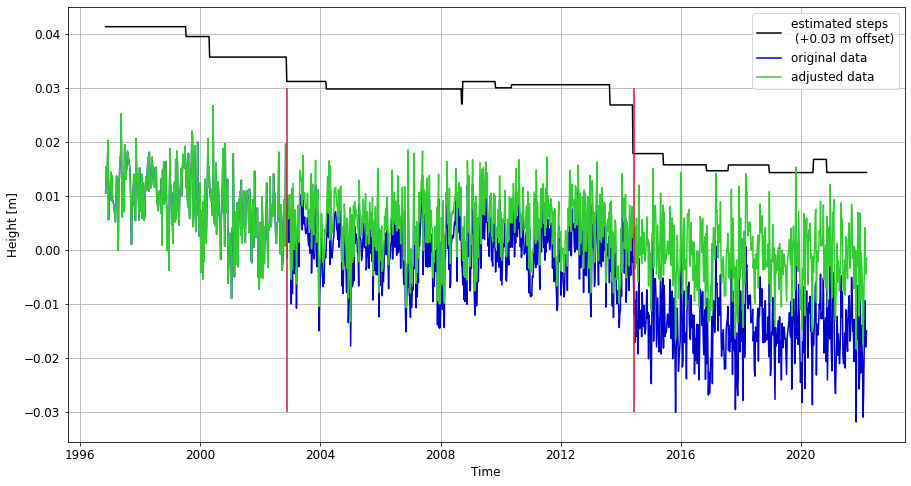

In [19]:
plt_dset1 = {'x_data':ngl.index, 'y_data':ls+0.03, 'label':'estimated steps\n (+0.03 m offset)'}
plt_dset2 = {'x_data':ngl.index, 'y_data':ngl_adjusted2['DU'], 'label':'adjusted data'}
plt_dset3 = {'x_data':ngl.index, 'y_data':ngl['DU'], 'label':'original data'}
plt_dset = [plt_dset1, plt_dset3,plt_dset2]
offsets = [idx1, idx2]
plot_timeseries(plt_dset, title='', offsets=offsets)

In [20]:
CD_statistics.compute_trend(ngl['decim_date'].values, ngl_adjusted2['DU'].values.astype('float')*1000) # mm/year

-0.5005

In [21]:
ngl_adjusted2 = ngl_adjusted2.rename(columns={'DU':'height[m]'})
ngl_adjusted2.to_csv(main_datapath_output + 'ngl_adjusted2.csv')

#### 3) Add the 4 mm offset at index 6

In [22]:
idx3 = 2
ngl_adjusted3 = pd.DataFrame(columns=['date', 'DU']).set_index(['date'])

for i in range(0,len(sections)):
    if i < 2:
        new_temp = pd.DataFrame({'DU':sections[i].loc[:, ('DU')]})  
    elif i < 3:
        new_temp = pd.DataFrame({'DU':sections[i].loc[:, ('DU')] - xs[idx3]})
    elif i < 10:
        new_temp = pd.DataFrame({'DU':sections[i].loc[:, ('DU')] - xs[idx2] - xs[idx3]})
    else:
        new_temp = pd.DataFrame({'DU':sections[i].loc[:, ('DU')] - xs[idx1] - xs[idx2] - xs[idx3]})
    ngl_adjusted3 = pd.concat([ngl_adjusted3, new_temp])

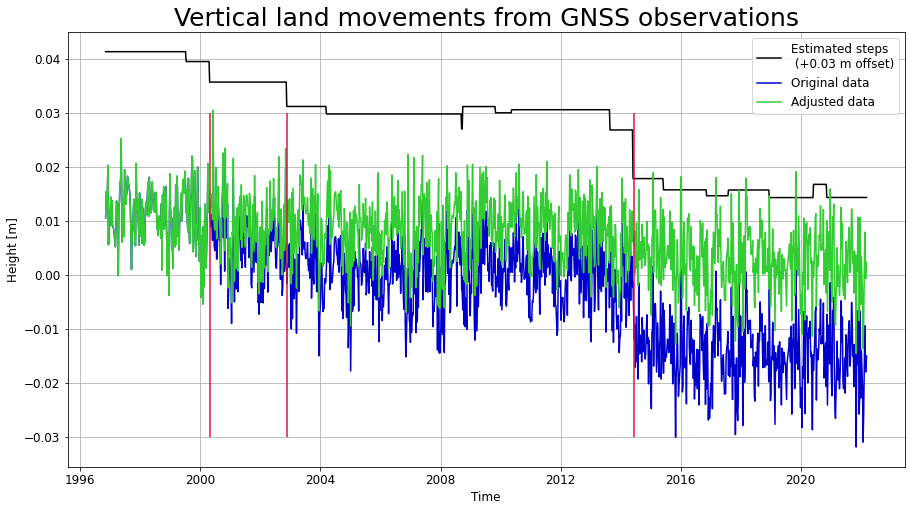

In [23]:
plt_dset1 = {'x_data':ngl.index, 'y_data':ls+0.03, 'label':'Estimated steps\n (+0.03 m offset)'}
plt_dset2 = {'x_data':ngl.index, 'y_data':ngl_adjusted3['DU'], 'label':'Adjusted data'}
plt_dset3 = {'x_data':ngl.index, 'y_data':ngl['DU'], 'label':'Original data'}
plt_dset = [plt_dset1, plt_dset3, plt_dset2]
offsets = [idx1, idx2, idx3]
plot_timeseries(plt_dset, title='Vertical land movements from GNSS observations', offsets=offsets)
plt.savefig('../99_plot_dump/ngl_version3.png', dpi=dpi)

In [24]:
CD_statistics.compute_trend(ngl['decim_date'].values, ngl_adjusted3['DU'].values.astype('float')*1000) # mm/year

-0.3949

In [25]:
ngl_adjusted3 = ngl_adjusted3.rename(columns={'DU':'height[m]'})
ngl_adjusted3.to_csv(main_datapath_output + 'ngl_adjusted3.csv')